# UPDRS Self Mutual Information
**Using pointwise isotonic fitting.**

**The Question:**
For each dimension of score, how much mutual information does previous measures contain?

**Approach:**
1. Load data from `train_clinical_data`, do data preprocessing.
    - *there are many things to do, add in the list*
    - for each record, inputs are:
        - previous clinical data;
        - outputs: propagation value

2. Refine information from the UPDRS data:
    - delta-change from previous UPDRS scoring
    - recent measurements in four UPDRS scores, and their corresponding sampling time points

3. Analyze mutual information (MI) between:
    - previous UPDRS 1 and UPDRS 1
    - previous UPDRS 1, 2, 3 and UPDRS 1

Examine how much information is missing from UPDRS alone. We are expecting to obtain from proteins and peptide measures.
    

**UPDRS measures and definitions**
| Part | Definition |
| --- | --- |
| I | Mentation, Behavior, Mood. |
| II | Activities of Daily Living |
| III | Motor Examination |
| IV | Complications of Therapy |

Read `train_clinical_data`, and get visualiszation of four UPDRS measures.

## A. Data Exploration

Load data from the csv file, view overall dataset distributions and sample patient propagations.

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from jpype import *
from jpype import _jpype
sys.path.insert(1, "G:\My Drive\CRS_CSYS5030\Project")
from preprocessing.paths import pointwise_features_path, pattern_features_path


# start the JVM kernel
jarLocation = R"G:\My Drive\CRS_CSYS5030\jidt\infodynamics.jar"
if (not(os.path.isfile(jarLocation))):
    raise FileNotFoundError(f"infordynamics.jar file not found: {jarLocation}")
if not _jpype.isStarted():
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

df_pointwise = pd.read_csv(pointwise_features_path)
df_pattern = pd.read_csv(pattern_features_path)

In [3]:
df_pointwise.head(3)

,patient_id,month,updrs_1,updrs_2,updrs_3,updrs_4,on_medication,clinical_visit,updrs_1_fit,updrs_2_fit,updrs_3_fit,updrs_4_fit,updrs_1_dt,updrs_2_dt,updrs_3_dt,updrs_4_dt,updrs_1_prev,updrs_2_prev,updrs_3_prev,updrs_4_prev
0,55,0,10.0,6.0,15.0,NaN,NaN,True,8.833333,6.000000,15.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,1,NaN,NaN,NaN,NaN,NaN,False,8.833333,6.333333,18.333333,0.0,0.0,0.333333,3.333333,0.0,8.833333,6.000000,15.000000,0.0
2,55,2,NaN,NaN,NaN,NaN,NaN,False,8.833333,6.666667,21.666667,0.0,0.0,0.333333,3.333333,0.0,8.833333,6.333333,18.333333,0.0


In [35]:
df_pattern.head(3)

,patient_id,month,updrs_1,updrs_2,updrs_3,updrs_4,on_medication,clinical_visit,updrs_1_fit,updrs_2_fit,...,updrs_3_dt,updrs_4_dt,delta_1,duration_1,delta_2,duration_2,delta_3,duration_3,delta_4,duration_4
0,55,0,10.0,6.0,15.0,NaN,NaN,True,8.833333,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,1,NaN,NaN,NaN,NaN,NaN,False,8.833333,6.333333,...,3.333333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55,2,NaN,NaN,NaN,NaN,NaN,False,8.833333,6.666667,...,3.333333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Overall data distribution

Distribution of 4 dimensions of UPDRS scores on record.

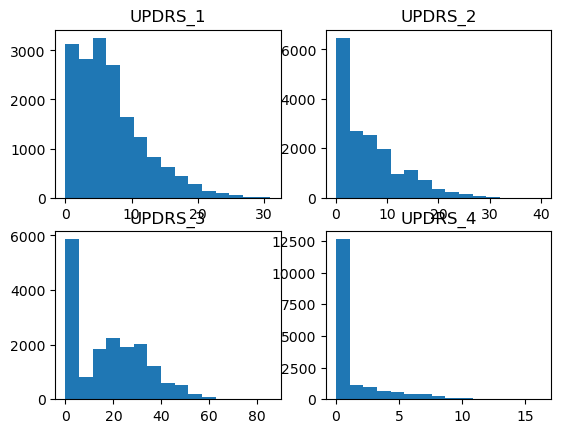

In [36]:
clinical_data = df_pointwise.copy()
fig, axs = plt.subplots(2,2,)
ax_flat = axs.flat
for i in range(4):
    ax = ax_flat[i]
    assert isinstance(ax, Axes)
    updrs_dimension = clinical_data[f'updrs_{int(i+1)}_fit']
    updrs_dimension = updrs_dimension[updrs_dimension.notna()]
    ax.set_title(f'UPDRS_{int(i+1)}')
    ax.hist(updrs_dimension, bins=15)

### Patient profile features
See the highest UPDRS scores in each fields which each patient can reach. This will give an idea of how to separate into stages. (Calculate how long it takes to reach the stage)

### Highest UPDRS reachable

What is the distribution of highest UPDRS a patient can reach?

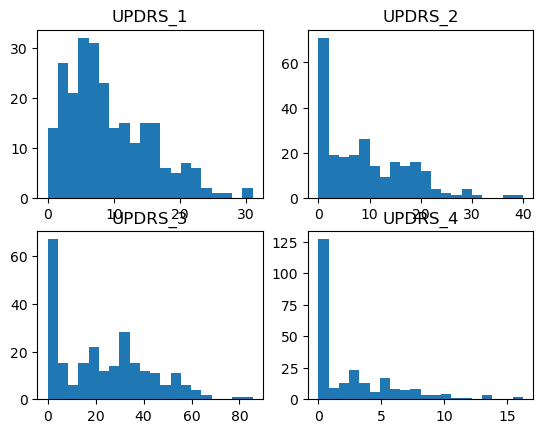

In [37]:
clinical_data_profile = clinical_data.copy()  # this df is for use by experiment 1 only.
clinical_data_profile.rename(
    columns={
        'upd23b_clinical_state_on_medication': 'on_medication',
        'visit_month': 'month'
        }, inplace=True)
clinical_data_profile.drop(columns=['on_medication'])
df_profile = clinical_data_profile.groupby(['patient_id'])

# plotting the distribution of maximum UPDRS reachable
max_updrs = df_profile[[f"updrs_{i}_fit" for i in (1,2,3,4)]].max()
max_updrs = max_updrs.fillna(0) # if all columns are missing, then max is 0

fig, axs = plt.subplots(2,2,)
ax_flat = axs.flat
for i in (1,2,3,4):
    ax = ax_flat[i-1]
    assert isinstance(ax, Axes)
    updrs_dimension = max_updrs[f'updrs_{i}_fit']
    updrs_dimension = updrs_dimension[updrs_dimension.notna()]
    ax.set_title(f'UPDRS_{i}')
    ax.hist(updrs_dimension, bins=20)


**Question:** How much mutual information does max UPDRS values hold about other UPDRS values?

Clustering patient profiles, by the maximum UPDRS scores in 4 dimensions

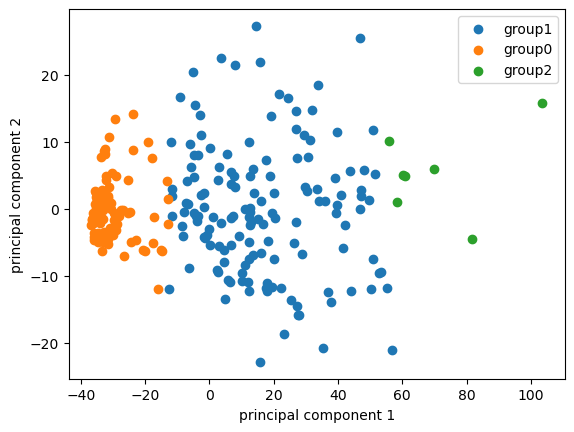

In [40]:
# kmeans clustering for max updrs features
# clf = KMeans(n_clusters=3)
clf = MeanShift()
clf.fit(max_updrs)
# patient_group_cluster = clf.transform(max_updrs)
# max_updrs['patient_group'] = patient_group_cluster.argmax(axis=1)
max_updrs['patient_group'] = clf.labels_

# pca scatter plot
pca=PCA(n_components=2)
pca.fit(max_updrs)
patient_group_pca = pca.transform(max_updrs)
max_updrs['pc_1'] = patient_group_pca[:,0]
max_updrs['pc_2'] = patient_group_pca[:,1]

for group in max_updrs['patient_group'].unique():
    patient_in_group = max_updrs[max_updrs['patient_group']==group]
    plt.scatter(patient_in_group['pc_1'], patient_in_group['pc_2'], label=f'group{group}')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.legend()
plt.show()

In [8]:
max_updrs

,updrs_1_fit,updrs_2_fit,updrs_3_fit,updrs_4_fit,patient_group,pc_1,pc_2
patient_id,,,,,,,
55,23.000000,21.000000,56.000000,0.0,2,36.535955,3.703065
942,6.000000,9.000000,39.000000,3.0,1,13.771968,-8.221611
1517,19.500000,18.000000,39.500000,10.0,2,20.760207,7.749185
1923,3.000000,0.250000,1.750000,0.0,0,-24.101450,-1.514197
2660,6.333333,0.000000,1.000000,0.0,0,-24.213566,1.280117
...,...,...,...,...,...,...,...
63875,4.400000,1.000000,2.000000,0.0,0,-23.335333,-0.166257
63889,6.800000,7.333333,28.000000,2.5,1,3.290104,-4.417842
64669,17.888889,17.000000,44.571429,0.0,2,23.730201,2.063308


In [75]:
pca.explained_variance_ratio_

array([0.8990974 , 0.06957155])

A violin chart showing the distributtions of UPDRS-1,2,3,4 in clusters

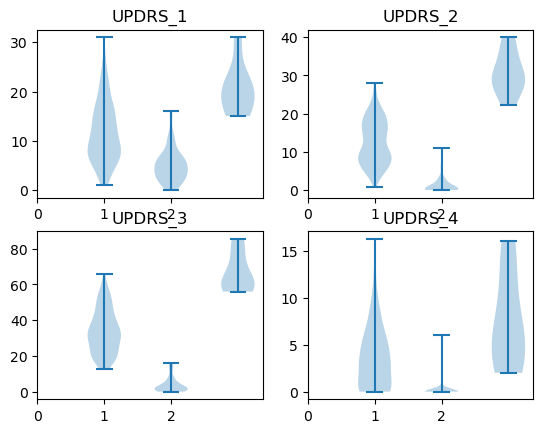

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()
group_labels = max_updrs['patient_group'].unique()
# for each updrs dimension, for each patient group
patient_group = max_updrs['patient_group']
for i, ax in zip((1, 2, 3, 4), axs):
    updrs_dimension = max_updrs[f'updrs_{i}_fit']
    updrs_dimension_groups = [
        updrs_dimension[patient_group == gl]
        for gl in group_labels
    ]
    ax.violinplot(updrs_dimension_groups)
    ax.set_title(f'UPDRS_{i}')
    ax.set_xticks(group_labels)

Meshgrid showing covariance of highest UPDRS 1,2,3,4 reachable.

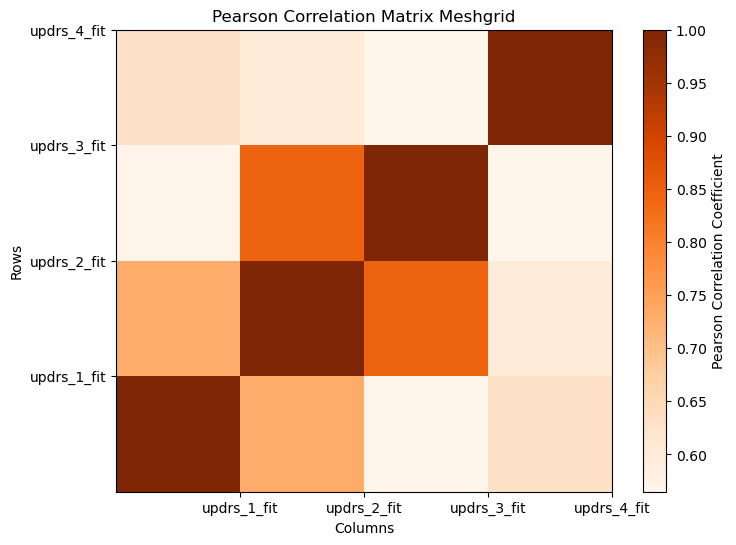

In [89]:
pearson_corr = max_updrs[[f'updrs_{i}_fit' for i in (1, 2, 3, 4)]].corr()

# Step 3: Create meshgrid
x, y = np.meshgrid(np.arange(len(pearson_corr.columns)), np.arange(len(pearson_corr.index)))

# Step 4: Plot the meshgrid
plt.figure(figsize=(8, 6))
plt.pcolormesh(x, y, pearson_corr, cmap='Oranges', shading='auto')
plt.colorbar(label='Pearson Correlation Coefficient')
plt.xticks(ticks=np.arange(len(pearson_corr.columns)) + 0.5, labels=pearson_corr.columns)
plt.yticks(ticks=np.arange(len(pearson_corr.index)) + 0.5, labels=pearson_corr.index)
plt.title('Pearson Correlation Matrix Meshgrid')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [11]:
max_updrs.groupby(['patient_group']).mean()[[f'updrs_{i}_fit' for i in (1,2,3,4)]]

,updrs_1_fit,updrs_2_fit,updrs_3_fit,updrs_4_fit
patient_group,,,,
0,5.086433,1.343691,3.832045,0.163158
1,9.998282,10.007622,27.013748,3.116258
2,15.296169,18.753114,48.666094,5.009776
3,31.000000,40.000000,85.500000,16.000000
4,20.625000,26.625000,72.000000,9.333333


### Sample patients
propagation for a few sample patient profiles

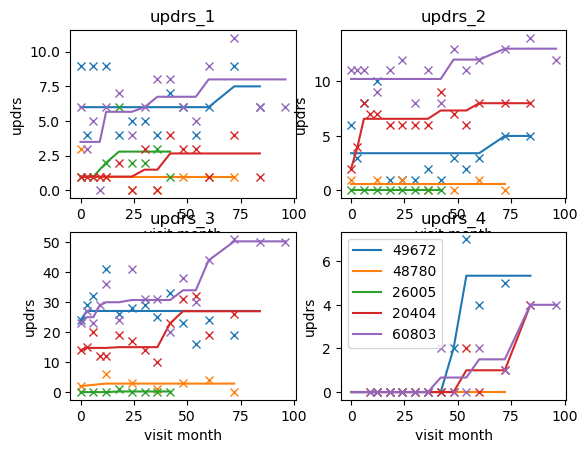

In [103]:
sample_patients = clinical_data['patient_id'].sample(5)
patients = clinical_data[clinical_data['patient_id'].isin(sample_patients)].groupby('patient_id')

fig, axs = plt.subplots(2,2,)
ax_flat = axs.flat
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
          "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
# for each patient, for four dimensions, plot
for i in range(4):
    ax = ax_flat[i]
    assert isinstance(ax, Axes)
    for j, patient in enumerate(sample_patients):
        patient_profile = clinical_data[clinical_data['patient_id'] == patient]
        # actual values
        df_updrs_actual = patient_profile[['month', f'updrs_{int(i+1)}']]
        df_updrs_actual = df_updrs_actual[df_updrs_actual.notna().all(axis=1)]
        # isotonic regression
        df_updrs_fit = patient_profile[['month', f'updrs_{int(i+1)}_fit']]
        df_updrs_fit = df_updrs_fit[df_updrs_fit.notna().all(axis=1)]
        # plot vlaues and isotonic fits
        color = colors[j]
        plt1 = ax.plot(df_updrs_actual['month'], df_updrs_actual[f'updrs_{int(i+1)}'], 
                       'x', color=color)
        plt2 = ax.plot(df_updrs_fit['month'], df_updrs_fit[f'updrs_{int(i+1)}_fit'],
                       label=str(patient), color=color)
        ax.set(xlabel='visit month', ylabel='updrs')
        ax.set_title(f'updrs_{int(i+1)}')
        if i == 3:
            ax.legend()

### Distribution of propagation speeds

Histograms showing the distributions of propagation speed, roughly following a Gaussian distribution.

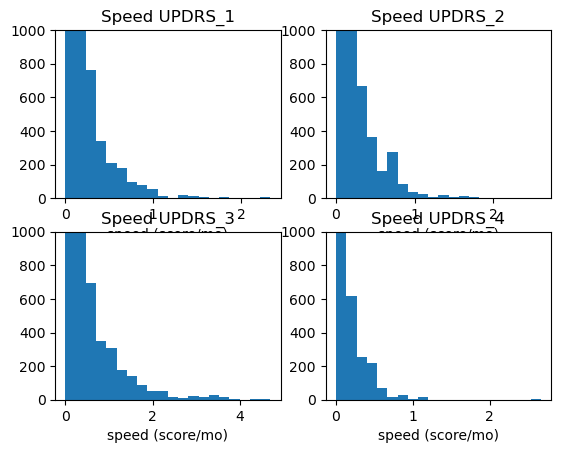

In [5]:
fig, axs = plt.subplots(2,2,)
ax_flat = axs.flat
for i in (1,2,3,4):
    ax = ax_flat[i-1]
    assert isinstance(ax, Axes)
    updrs_speed = df_pointwise[f'updrs_{i}_dt']
    updrs_speed = updrs_speed[updrs_speed.notna()]
    ax.set_title(f'Speed UPDRS_{i}')
    ax.set_xlabel('speed (score/mo)')
    ax.hist(updrs_speed, bins=20)
    ax.set_ylim(0, 1000)


## B. Information Theory Analysis
1. normalize "on_medication" status.
2. interpolation for null updrs values, keep track of interpolation.

### Pointwise Features

**ignoring UPDRS 4**
UPDRS 4 has many missing data, so we will ignore for now.
UPDRS 4, defined as complications of therapy is dependent on clinical decision
so it's dependent on updrs 1,2,3

**removing null**
In updrs 1,2,3, 2615 records, has 2588 not containing null. We filter out the records containing null

#### Distributions of speed and UPDRS

In the `clinical_data` table without null values, we will create following feature-columns:
- shift columns to get previous `visit_month` and `updrs_1,2,3`.
- group by `patient_id`.
- calculate delta value of month, `month_delta`, using `month - month_prev`.
- calculate delta value for UPDRS 1,2,3, using `(updrs_i - updrs_i_prev) / month_delta`.
- drop null rows, they should be first month which has no delta.
- delta values for UPDRS 1,2,3.

<!--NOTES:
check if groupby works.
analyzing MI do require records from all patients, single profile is too small.
if groupby doesn't work, iterate over profiles, and concatenate delta, prev into 
-->


In [40]:
visit_data = clinical_data[clinical_data['clinical_visit']]
print('original dataset:', visit_data.shape)
print(
    'not null in updrs 1,2,3,4:',
    visit_data[visit_data.notna().all(axis=1)].shape)
print(
    'not null in updrs 1,2,3:',
    visit_data[visit_data[[f'updrs_{i}' for i in (1,2,3)]].notna().all(axis=1)].shape)

original dataset: (2615, 16)
not null in updrs 1,2,3,4: (1216, 16)
not null in updrs 1,2,3: (2588, 16)


1. get mutual information of UPDRS-1 with previous, $MI(x_i, x_{i-1})$

Text(0, 0.5, 'dx/dt for updrs 1')

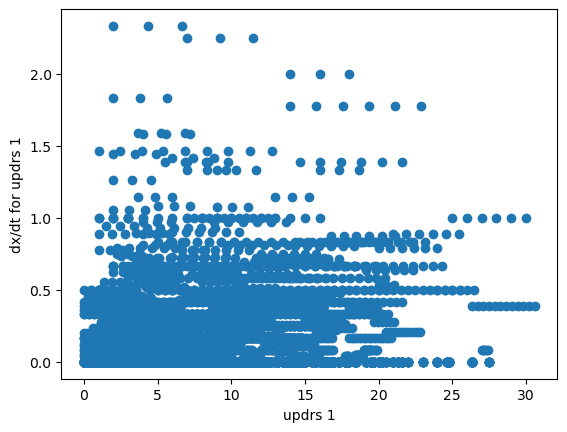

In [48]:
# visualizing the dx/dt (y) vs prev_x
plt.scatter(clinical_data['updrs_1_prev'].tolist(), clinical_data['updrs_1_dt'].tolist())
plt.xlabel('updrs 1')
plt.ylabel('dx/dt for updrs 1')

Text(0, 0.5, 'dx/dt updrs 3')

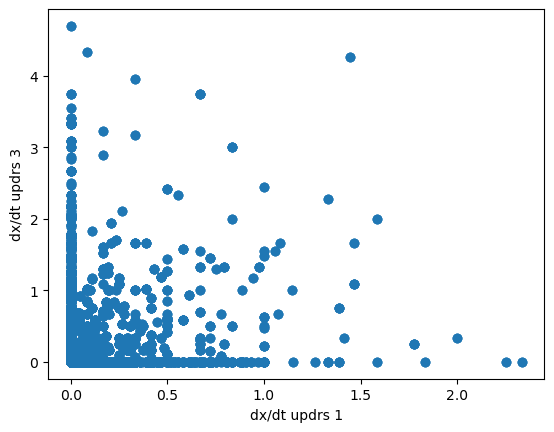

In [49]:
# plot of d updrs_1 / dt and d updrs_3 / dt relations
plt.scatter(clinical_data['updrs_1_dt'].tolist(), clinical_data['updrs_3_dt'].tolist())
plt.xlabel('dx/dt updrs 1')
plt.ylabel('dx/dt updrs 3')

Text(0, 0.5, 'next updrs-1 value')

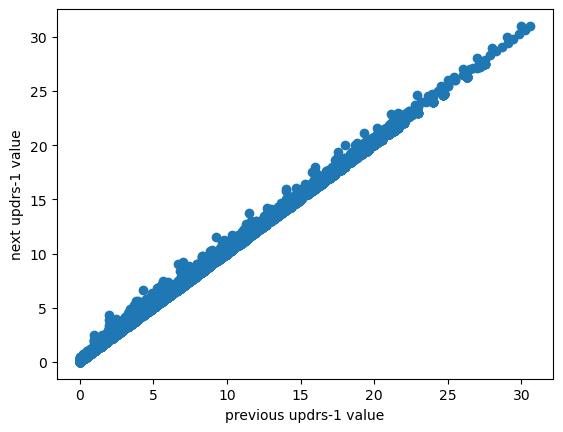

In [50]:
plt.scatter(clinical_data['updrs_1_prev'].tolist(), clinical_data['updrs_1_fit'].tolist())
plt.xlabel('previous updrs-1 value')
plt.ylabel('next updrs-1 value')

In [52]:
# mutual information using sklearn method
from sklearn.metrics import normalized_mutual_info_score as nmis

# mutual information between current propagation speed and previous propagation
df_nmis = clinical_data[['updrs_1_prev', 'updrs_1_dt']]
df_nmis = df_nmis[df_nmis.notna().all(axis=1)]
print('UPDRS propagation speed from previous value:',
    nmis(df_nmis['updrs_1_prev'].tolist(), df_nmis['updrs_1_dt'].tolist()))


UPDRS propagation speed from previous value: 0.34539252643244167


d:\conda_envs\envs\crs_csys5030\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [54]:
df_nmis = clinical_data[['updrs_1_dt', 'updrs_3_dt']]
df_nmis = df_nmis[df_nmis.notna().all(axis=1)]
nmis(df_nmis['updrs_1_dt'].tolist(), df_nmis['updrs_3_dt'].tolist())


d:\conda_envs\envs\crs_csys5030\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


0.22461430994747184

#### Self Mutual Information
Mutual information MI(dx[i]/dt, x[i-1], dx[i-1]/dt)

In [43]:
# mutual information using jidt

# TODO: rewrite source destination data
# histories = (clinical_data_e1_g[f'updrs_{i}'].apply(
#         lambda group: group.shift(1)) for i in (1,2,3))

# 1. Construct the calculator:
Ksg = JPackage("infodynamics.measures.continuous.kraskov")\
    .MutualInfoCalculatorMultiVariateKraskov1
ksg_calc = Ksg()

for i in (1, 2, 3):

    # A. entropy of propagation speed using Gaussian
    # 0. Load/prepare the data:
    speeds = clinical_data[f'updrs_{i}_dt']
    speeds = speeds[speeds.notna()]
    variable = JArray(JDouble, 1)(speeds.to_numpy())

    # # 1. Construct the calculator:
    # GaussEntropy = JPackage("infodynamics.measures.continuous.gaussian").EntropyCalculatorGaussian
    # entropy_calc = GaussEntropy()
    # # 2. Set any properties to non-default values:
    # # No properties were set to non-default values
    # # 3. Initialise the calculator for (re-)use:
    # entropy_calc.initialise()
    # # 4. Supply the sample data:
    # entropy_calc.setObservations(variable)
    # # 5. Compute the estimate:
    # entropy_value = entropy_calc.computeAverageLocalOfObservations()

    # # New Method: use KSG to calculate H(X) = MI(X;X)
    # Initialise the calculator
    # 3. Initialise the calculator for (re-)use:
    ksg_calc.initialise()
    # 4. Supply the sample data:
    ksg_calc.setObservations(variable, variable)
    # 5. Compute the estimate:
    entropy_value = ksg_calc.computeAverageLocalOfObservations()
    
    # B. mutual information of propagation speed and UPDRS
    # 0. Load/prepare the data:
    s_source = clinical_data[f'updrs_{i}_dt']
    s_target = clinical_data[f'updrs_{i}_prev']
    notna = s_source.notna() * s_target.notna()
    s_source = s_source[s_source.notna()]
    s_target = s_target[s_target.notna()]
    source = JArray(JDouble, 1)(s_source.to_numpy())
    destination = JArray(JDouble, 1)(s_target.to_numpy())
    
    # 2. Set any properties to non-default values:
    # No properties were set to non-default values
    # 3. Initialise the calculator for (re-)use:
    ksg_calc.initialise()
    # 4. Supply the sample data:
    ksg_calc.setObservations(source, destination)
    # 5. Compute the estimate:
    mi_value = ksg_calc.computeAverageLocalOfObservations()

    # output results
    print("H_Gaussian(UPDRS-%s) = %.4f nats" %\
        (i, entropy_value))
    print("MI_Kraskov (KSG) alg. 1(UPDRS-%s, dx[i]/dt & x[i-1]) = %.4f nats" %\
        (i, mi_value))

H_Gaussian(UPDRS-1) = 1.6267 nats
MI_Kraskov (KSG) alg. 1(UPDRS-1, dx[i]/dt & x[i-1]) = 0.3019 nats
H_Gaussian(UPDRS-2) = 1.4839 nats
MI_Kraskov (KSG) alg. 1(UPDRS-2, dx[i]/dt & x[i-1]) = 0.3643 nats
H_Gaussian(UPDRS-3) = 1.8193 nats
MI_Kraskov (KSG) alg. 1(UPDRS-3, dx[i]/dt & x[i-1]) = 0.3807 nats


Calculation using scipy.stats.differential_entropy.

#### Conditional MI, speed and UPDRS

Conditional mutual information, given patient group in 0, 1 and 2.

In [42]:
df_e1_group = pd.merge(
    clinical_data, max_updrs['patient_group'],
    left_on=['patient_id'], right_on=['patient_id'])
GaussEntropy = JPackage("infodynamics.measures.continuous.gaussian")\
    .EntropyCalculatorGaussian

Ksg = JPackage("infodynamics.measures.continuous.kraskov")\
    .MutualInfoCalculatorMultiVariateKraskov1
# construct calculator
ksg_calc = Ksg()
# initialise the calculator


for group in df_e1_group['patient_group'].unique():
    print(f"group {group}")
    df_in_group = df_e1_group[df_e1_group['patient_group']==group]
    for i in (1,2,3):
        print(f'\tUPDRS {i}')
        # A. entropy of propagation speed using Gaussian
        # 0. Load/prepare the data:
        speeds = df_in_group[f'updrs_{i}_dt']
        speeds = speeds[speeds.notna()]
        variable = JArray(JDouble, 1)(speeds.to_numpy())
        
        # # New Method: use KSG to calculate H(X) = MI(X;X)
        # Initialise the calculator
        # 3. Initialise the calculator for (re-)use:
        ksg_calc.initialise()
        # 4. Supply the sample data:
        ksg_calc.setObservations(variable, variable)
        # 5. Compute the estimate:
        entropy_value = ksg_calc.computeAverageLocalOfObservations()

        # # Old Method: use gaussian entropy calculators to calculate entropy
        # # 1. Construct the calculator:
        # entropy_calc = GaussEntropy()
        # # 2. Set any properties to non-default values:
        # # No properties were set to non-default values
        # # 3. Initialise the calculator for (re-)use:
        # entropy_calc.initialise()
        # # 4. Supply the sample data:
        # entropy_calc.setObservations(variable)
        # # 5. Compute the estimate:
        # entropy_value = entropy_calc.computeAverageLocalOfObservations()

        # B. mutual information of propagation speed and UPDRS
        s_source = df_in_group[f'updrs_{i}_dt']
        s_target = df_in_group[f'updrs_{i}_prev']
        notna = s_source.notna() * s_target.notna()
        s_source = s_source.notna()
        s_target = s_target.notna()
        source = JArray(JDouble, 1)(s_source.to_numpy())
        destination = JArray(JDouble, 1)(s_target.to_numpy())
        # 1. Construct the calculator, done above
        # 2. Set any properties to non-default values:
        # No properties were set to non-default values
        # 3. Initialise the calculator for (re-)use:
        ksg_calc.initialise()
        # 4. Supply the sample data:
        ksg_calc.setObservations(source, destination)
        # 5. Compute the estimate:
        mi_value = ksg_calc.computeAverageLocalOfObservations()

        # output results
        print("\tH_Gaussian(dx[i]/dt) = %.4f nats" %\
            (entropy_value))
        print("\tMI_Kraskov (KSG) alg. 1(UPDRS-%s, dx[i]/dt & x[i-1]) = %.4f nats" %\
            (i, mi_value))

group 1
	UPDRS 1
	H_Gaussian(dx[i]/dt) = 1.7111 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-1, dx[i]/dt & x[i-1]) = 0.0747 nats
	UPDRS 2
	H_Gaussian(dx[i]/dt) = 1.8485 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-2, dx[i]/dt & x[i-1]) = 0.0772 nats
	UPDRS 3
	H_Gaussian(dx[i]/dt) = 1.9994 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-3, dx[i]/dt & x[i-1]) = 0.0760 nats
group 0
	UPDRS 1
	H_Gaussian(dx[i]/dt) = 1.2919 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-1, dx[i]/dt & x[i-1]) = 0.0673 nats
	UPDRS 2
	H_Gaussian(dx[i]/dt) = 0.5791 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-2, dx[i]/dt & x[i-1]) = 0.0714 nats
	UPDRS 3
	H_Gaussian(dx[i]/dt) = 1.1975 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-3, dx[i]/dt & x[i-1]) = 0.0732 nats
group 2
	UPDRS 1
	H_Gaussian(dx[i]/dt) = 1.6308 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-1, dx[i]/dt & x[i-1]) = 0.0900 nats
	UPDRS 2
	H_Gaussian(dx[i]/dt) = 2.0028 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-2, dx[i]/dt & x[i-1]) = 0.0632 nats
	UPDRS 3
	H_Gaussian(dx[i]/dt) = 2.2964 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-3, d

#### Cross dimensional MI

Confusion matrix shows mutual informations of propagation speeds across UPDRS dimensions.

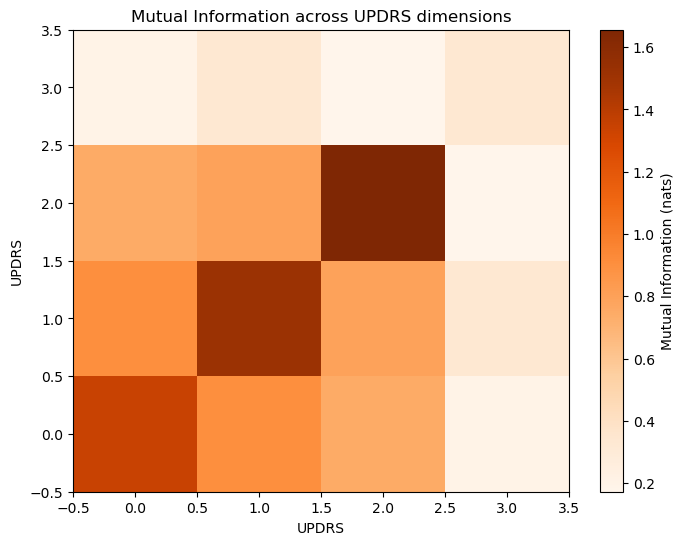

In [88]:
x, y = np.meshgrid(np.arange(4), np.arange(4))
cross_mi = np.ones((4, 4), dtype='float')
Ksg = JPackage("infodynamics.measures.continuous.kraskov")\
    .MutualInfoCalculatorMultiVariateKraskov1

for i in np.arange(0, cross_mi.shape[0], 1):
    for j in np.arange(i, cross_mi.shape[0], 1):
        s_source = df_in_group[f'updrs_{i+1}_dt']
        s_target = df_in_group[f'updrs_{j+1}_dt']
        notna = s_source.notna() * s_target.notna()
        s_source = s_source[notna]
        s_target = s_target[notna]
        source = JArray(JDouble, 1)(s_source.to_numpy())
        destination = JArray(JDouble, 1)(s_target.to_numpy())
        ksg_calc = Ksg()
        ksg_calc.initialise()
        ksg_calc.setObservations(source, destination)
        mi_value = ksg_calc.computeAverageLocalOfObservations()
        cross_mi[i][j] = mi_value
        cross_mi[j][i] = mi_value

# Step 4: Plot the meshgrid
plt.figure(figsize=(8, 6))
plt.pcolormesh(x, y, cross_mi, cmap='Oranges', shading='auto')
plt.colorbar(label='Mutual Information (nats)')
# plt.xticks(ticks=np.arange(len(pearson_corr.columns)) + 0.5, labels=pearson_corr.columns)
# plt.yticks(ticks=np.arange(len(pearson_corr.index)) + 0.5, labels=pearson_corr.index)
plt.title('Mutual Information across UPDRS dimensions')
plt.xlabel('UPDRS')
plt.ylabel('UPDRS')
plt.show()

### Active Information Storage

Considering single UPDRS dimensions. How much information from historic data is useful in predicting the future value.

#### Optimizing k and tau

First, fix the value $k=3$ to compute the optimized value of $\tau$.


In [10]:
# As numpy array:
data = df_pointwise['updrs_1_dt']
data = data[data.notna()]

# FIXME: should group by patient profile
# for tau in (1, 2):  # , 3, 6):
tau = 1
for k in np.arange(2,12,1):
    # 0. Load/prepare the data:
    variable = JArray(JDouble, 1)(data[:-k].tolist())
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.continuous.kraskov")\
        .ActiveInfoStorageCalculatorKraskov
    calc = calcClass()
    # 2. Set any properties to non-default values:
    calc.setProperty("AUTO_EMBED_METHOD", "MAX_CORR_AIS")
    calc.setProperty("AUTO_EMBED_K_SEARCH_MAX", "7")
    calc.setProperty("AUTO_EMBED_TAU_SEARCH_MAX", "3")
    calc.setProperty("USE_GPU", "true")
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(variable)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    print("AIS_Kraskov (KSG)(k=%s)(tau=%s) = %.4f nats" %\
        (k, tau, result))


java.lang.Exception: java.lang.Exception: Exception encountered in attempting auto-embedding, evaluating candidates k=1, tau=1

Compute AIS for each individual patient profile, find $k$ and $\tau$ that optimizes the average AIS.

In [6]:
data = df_pointwise['updrs_1_dt']
data = data[data.notna()]
ais_columns = ['patient_id'] + [f'updrs_{i}_dt' for i in (1,2,3,4)]
df_ais = df_pointwise[ais_columns]

def ais_value(
        variable: pd.Series, k: int, tau: int,
        calcClass: object = None) -> float:
    """
    calculate ais value within single patient profile
    inputs:
        variable: pd.Series
    """
    # handling insufficient number of variables
    if len(variable) < 3 * k * tau:
        return np.nan
    # 0. Load/prepare the data:
    variable = JArray(JDouble, 1)(data[:-k].tolist())
    # 1. Construct the calculator:
    if calcClass is None:
        calcClass = JPackage("infodynamics.measures.continuous.kraskov")\
            .ActiveInfoStorageCalculatorKraskov
    calc = calcClass()
    # 2. Set any properties to non-default values:
    calc.setProperty("k_HISTORY", str(k))
    calc.setProperty("TAU", str(tau))
    # calc.setProperty("USE_GPU", "true")
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(variable)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    return result

# # FIXME: should group by patient profile
# updrs_column = 'updrs_1_dt'
# aisClass = JPackage("infodynamics.measures.continuous.kraskov")\
#     .ActiveInfoStorageCalculatorKraskov
# ais_values = {'k': [], 'tau': [], 'mean ais': []}
# for k in np.arange(1,3,1):
#     for tau in (1, 3, 6):
#         ais_patient = df_ais.groupby('patient_id').apply(
#             lambda group: ais_value(group[updrs_column], k, tau, aisClass),
#         )
#         mean_ais = ais_patient[ais_patient.notna()].mean()
#         ais_values['k'].append(k)
#         ais_values['tau'].append(tau)
#         ais_values['mean ais'].append(mean_ais)
# ais_values = pd.DataFrame(ais_values).sort_values(by='mean ais')
# ais_values


#### Distributions of sample length

The histogram below shows distributions of sample time series lengths, in months.

(array([ 1.,  1.,  0.,  6.,  5.,  0., 19., 11.,  0., 28.,  6.,  0., 44.,
         0.,  0., 22.,  0.,  0., 46.,  0.,  0., 47.,  0.,  0., 12.]),
 array([ 12.  ,  15.84,  19.68,  23.52,  27.36,  31.2 ,  35.04,  38.88,
         42.72,  46.56,  50.4 ,  54.24,  58.08,  61.92,  65.76,  69.6 ,
         73.44,  77.28,  81.12,  84.96,  88.8 ,  92.64,  96.48, 100.32,
        104.16, 108.  ]),
 <BarContainer object of 25 artists>)

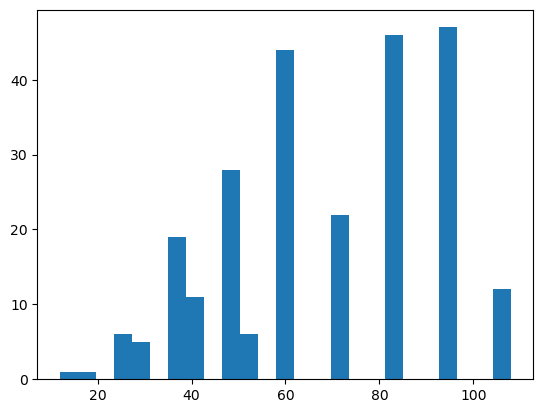

In [3]:
# length of updrs fit time string
data = df_pointwise['updrs_1_dt']
data = data[data.notna()]
ais_columns = ['patient_id'] + [f'updrs_{i}_dt' for i in (1,2,3,4)]
df_ais = df_pointwise[ais_columns]
time_series_lengths = df_ais.groupby('patient_id')['updrs_1_dt'].count().sort_values(ascending=True)
plt.hist(time_series_lengths, bins=25)
# df_ais.groupby('patient_id')

Compute mean AIS across patient profiles, weighting over number of actual clinical testings for each patient.

In [7]:
# TODO: optimize k, tau, and analyze AIS on UPDRS-2,3,4
aisClass = JPackage("infodynamics.measures.continuous.kraskov")\
    .ActiveInfoStorageCalculatorKraskov
ais_values = {'updrs': [], 'k': [], 'mean ais': []}

for i in (1,2,3,4):
    # get the optimal ais value with k and tau
    updrs_column = f'updrs_{i}_dt'
    best_ais = -100
    for k in np.arange(1,9,1):
        tau = 1
        ais_patient = df_ais.groupby('patient_id').apply(
            lambda group: ais_value(group[updrs_column], k, tau, aisClass),
        )
        mean_ais = ais_patient[ais_patient.notna()].mean()
        ais_values['updrs'].append(i)
        ais_values['k'].append(k)
        ais_values['mean ais'].append(mean_ais)
ais_values = pd.DataFrame(ais_values)
# .sort_values(by='mean ais', ascending=False)
ais_values


C:\Users\user\AppData\Local\Temp\ipykernel_43828\3852217325.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ais_patient = df_ais.groupby('patient_id').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_43828\3852217325.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ais_patient = df_ais.groupby('patient_id').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_43828\3852217325.py:12: DeprecationWarnin

,updrs,k,mean ais
0,1,1,1.242308
1,1,2,1.211433
2,1,3,1.190086
3,1,4,1.167243
4,1,5,1.148501
5,1,6,1.140362
6,1,7,1.141087
7,1,8,1.105227
8,2,1,1.242185
9,2,2,1.211583
